# Exploratory Data Analysis

### Load Libraries
Load the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
import warnings
warnings.filterwarnings("ignore")

### EDA for METAR Dataset

In [3]:
metar_decoded = pd.read_csv('../data/metar_engineered.csv')
metar_decoded.head()

,Unnamed: 0,AIRPORT_IATA,AIRPORT_ICAO,UTC DATE/TIME,METAR,DESCRIPTION,Date Time,Hour,Date,Wind_direction,Wind_speed,Temperature,Dew_point,Pressure,Visibility
0,0,LHR,EGLL,2019-05-18 23:50:00,EGLL 182350Z AUTO 01003KT 9999 NCD 11/09 Q1009...,Day: 18th Time: 23:50 UTC Wind direction: 10 W...,2019-05-18 23:50:00,23,2019-05-18,10.0,3.0,11.0,9.0,1009.0,9999.0
1,1,LHR,EGLL,2019-05-18 23:20:00,EGLL 182320Z AUTO 02002KT 9999 NCD 10/08 Q1009...,Day: 18th Time: 23:20 UTC Wind direction: 20 W...,2019-05-18 23:20:00,23,2019-05-18,20.0,2.0,10.0,8.0,1009.0,9999.0
2,2,LHR,EGLL,2019-05-18 22:50:00,EGLL 182250Z AUTO 04002KT 9999 NCD 12/09 Q1009...,Day: 18th Time: 22:50 UTC Wind direction: 40 W...,2019-05-18 22:50:00,22,2019-05-18,40.0,2.0,12.0,9.0,1009.0,9999.0
3,3,LHR,EGLL,2019-05-18 22:20:00,EGLL 182220Z AUTO 06002KT 9999 NCD 12/09 Q1008,Day: 18th Time: 22:20 UTC Wind direction: 60 W...,2019-05-18 22:20:00,22,2019-05-18,60.0,2.0,12.0,9.0,1008.0,9999.0
4,4,LHR,EGLL,2019-05-18 21:50:00,EGLL 182150Z AUTO VRB02KT 9999 NCD 13/09 Q1008...,Day: 18th Time: 21:50 UTC Wind speed: 2kt Temp...,2019-05-18 21:50:00,21,2019-05-18,NaN,2.0,13.0,9.0,1008.0,9999.0


In [4]:
metar_decoded = metar_decoded.drop(['Unnamed: 0','Date Time'],axis=1)

In [5]:
metar_decoded.isnull().sum()

AIRPORT_IATA         0
AIRPORT_ICAO         0
UTC DATE/TIME        0
METAR                0
DESCRIPTION          0
Hour                 0
Date                 0
Wind_direction    1393
Wind_speed           4
Temperature         91
Dew_point          161
Pressure            91
Visibility        3521
dtype: int64

In [6]:
metar_decoded.corr()

,Hour,Wind_direction,Wind_speed,Temperature,Dew_point,Pressure,Visibility
Hour,1.000000,0.027679,0.134475,0.233538,0.022742,0.002692,0.030227
Wind_direction,0.027679,1.000000,0.232210,-0.186782,-0.318679,0.093845,0.132215
Wind_speed,0.134475,0.232210,1.000000,0.237427,-0.044134,-0.195382,-0.126798
Temperature,0.233538,-0.186782,0.237427,1.000000,0.477084,-0.210307,-0.192292
Dew_point,0.022742,-0.318679,-0.044134,0.477084,1.000000,-0.259575,-0.275709
Pressure,0.002692,0.093845,-0.195382,-0.210307,-0.259575,1.000000,0.963457
Visibility,0.030227,0.132215,-0.126798,-0.192292,-0.275709,0.963457,1.000000


In [7]:
missing_columns = ["Wind_direction", "Wind_speed", "Temperature", "Dew_point", "Pressure"]

In [8]:
def random_imputation(metar_decoded, feature):

    number_missing = metar_decoded[feature].isnull().sum()
    observed_values = metar_decoded.loc[metar_decoded[feature].notnull(), feature]
    metar_decoded.loc[metar_decoded[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return metar_decoded

In [9]:
for feature in missing_columns:
    metar_decoded[feature + '_imp'] = metar_decoded[feature]
    metar_decoded = random_imputation(metar_decoded, feature)

In [10]:
num_columns_and_imp = ["Hour", "Wind_direction_imp", "Wind_speed_imp", "Temperature_imp", "Dew_point_imp", "Pressure_imp"]

In [11]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = metar_decoded[feature + '_imp']
    parameters = list(set(num_columns_and_imp) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = metar_decoded[parameters], y = metar_decoded[feature + '_imp'])
    
    #Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(metar_decoded[parameters])
    std_error = (predict[metar_decoded[feature].notnull()] - metar_decoded.loc[metar_decoded[feature].notnull(), feature + '_imp']).std()
    
    #observe that I preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = metar_decoded[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(metar_decoded[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(metar_decoded[feature].isnull()) & 
                                                                            (random_predict > 0)]

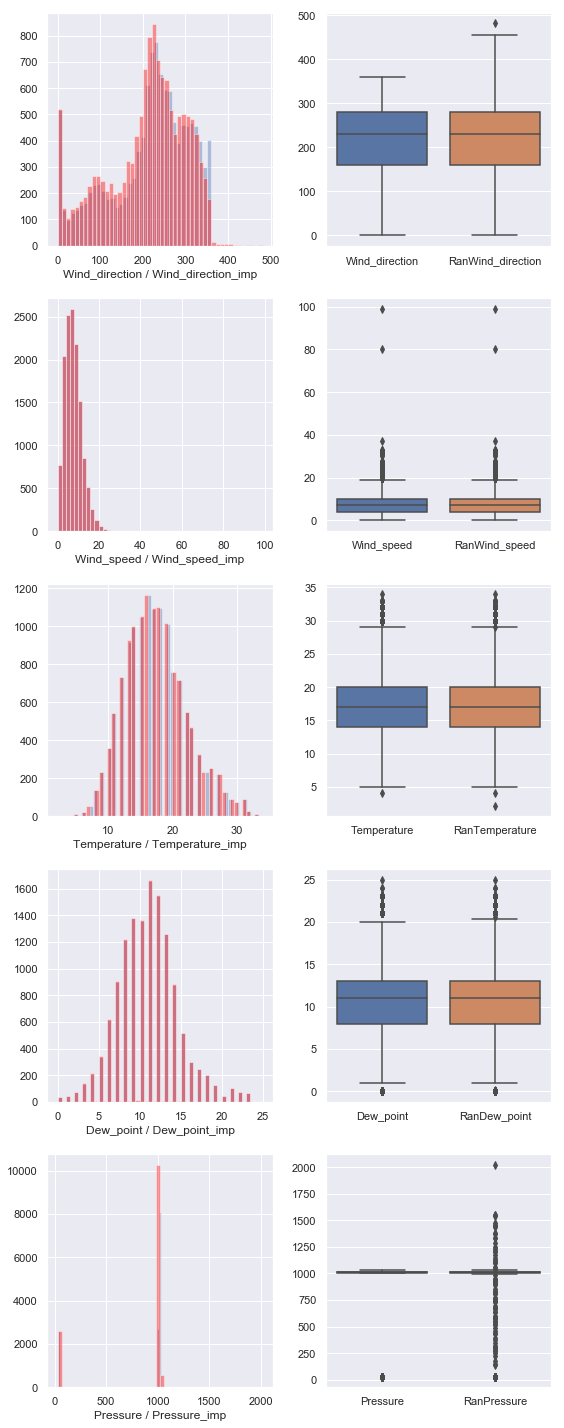

In [12]:
sns.set()
fig, axes = plt.subplots(nrows = len(missing_columns), ncols = 2)
fig.set_size_inches(8, 20)

for index, variable in enumerate(missing_columns):
    sns.distplot(metar_decoded[variable].dropna(), kde = False, ax = axes[index, 0])
    sns.distplot(random_data["Ran" + variable], kde = False, ax = axes[index, 0], color = 'red')
    axes[index, 0].set(xlabel = variable + " / " + variable + '_imp')
    
    sns.boxplot(data = pd.concat([metar_decoded[variable], random_data["Ran" + variable]], axis = 1),
                ax = axes[index, 1])
    
    plt.tight_layout()

In [13]:
metar_decoded_engineered = metar_decoded[['AIRPORT_IATA','Date','Hour','Wind_direction_imp','Wind_speed_imp','Temperature_imp','Dew_point_imp','Pressure_imp']]

In [14]:
metar_decoded_engineered.to_csv('../data/metar_decoded_engineered.csv')

### EDA for Arrival_Departures Dataset

In [15]:
arrivals_departures_extended = pd.read_csv('../data/arrivals_departures_engineered.csv')
arrivals_departures_extended.head()

,Unnamed: 0,index,mode,flight_number,callsign,aircraft_model_code,aircraft_model_description,aircraft_registration,airline_name,airline_iata,...,flight_departure_scheduled,flight_departure_real,flight_arrival_scheduled,flight_arrival_real,flight_duaration,target,Hour_departures,Date_departures,Hour_arrivals,Date_arrivals
0,0,0,arrivals,JL41,JAL41,B788,Boeing 787-8 Dreamliner,JA837J,Japan Airlines,JL,...,1558284900,1.558287e+09,1558329900,1.558329e+09,41940.0,neither delay nor cancel,17,2019-05-19,6,2019-05-20
1,1,1,arrivals,SA234,SAA234,A333,Airbus A330-343,ZS-SXK,South African Airways,SA,...,1558288800,1.558290e+09,1558329900,1.558329e+09,39720.0,neither delay nor cancel,19,2019-05-19,6,2019-05-20
2,2,2,arrivals,QF1,QFA1,A388,Airbus A380-842,VH-OQA,Qantas,QF,...,1558281300,1.558286e+09,1558329900,1.558333e+09,46860.0,delay,16,2019-05-19,6,2019-05-20
3,3,3,arrivals,BI3,RBA003,B788,Boeing 787-8 Dreamliner,V8-DLD,Royal Brunei Airlines,BI,...,1558277700,1.558278e+09,1558329900,1.558329e+09,51120.0,neither delay nor cancel,15,2019-05-19,6,2019-05-20
4,4,4,arrivals,VS4,VIR4C,A333,Airbus A330-343,G-VWAG,Virgin Atlantic,VS,...,1558303200,1.558306e+09,1558329900,1.558329e+09,23220.0,neither delay nor cancel,23,2019-05-19,6,2019-05-20


In [16]:
arrivals_departures_extended = arrivals_departures_extended.drop(['Unnamed: 0','index', 'callsign','aircraft_model_description','aircraft_model_code','aircraft_registration',
                             'flight_origin_time_offset','flight_destination_time_offset',
                             'airline_icao','flight_origin_code_icao','flight_destination_code_icao'
                             ],axis=1)

In [17]:
arrivals_extended = arrivals_departures_extended[arrivals_departures_extended['mode'] == 'arrivals'].reset_index()
arrivals_extended.shape

(145495, 19)

In [18]:
arrivals_extended.to_csv('../data/arrivals_extended_egineered.csv')

In [19]:
departures_extended = arrivals_departures_extended[arrivals_departures_extended['mode'] == 'departures'].reset_index()
departures_extended.shape

(136638, 19)

In [20]:
departures_extended.to_csv('../data/departures_extended_egineered.csv')

### Flight Arrival Analysis

In [21]:
target_group = pd.DataFrame(arrivals_extended['target'].value_counts().rename_axis('target').reset_index(name='count'))
target_group['percentage'] = (target_group['count'] / target_group['count'].sum()) * 100
target_group.head()

,target,count,percentage
0,neither delay nor cancel,92952,63.886732
1,delay,45918,31.559847
2,cancel,6625,4.553421


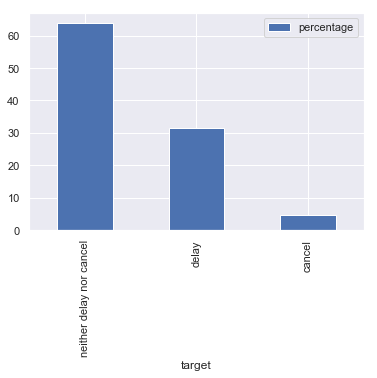

In [22]:
target_group.plot(kind='bar', x='target', y='percentage')

In [23]:
target_group_airline = pd.DataFrame({'count' : arrivals_extended.groupby(['airline_name','target']).size()}).reset_index()
target_group_airline_pivot = pd.DataFrame(target_group_airline.pivot('airline_name','target','count').to_records())
target_group_airline_pivot.shape

(878, 4)

In [24]:
target_group_airline_pivot.head()

,airline_name,cancel,delay,neither delay nor cancel
0,21 Air,1.0,NaN,NaN
1,ABX Air,9.0,36.0,40.0
2,ASL Airlines Belgium,4.0,3.0,3.0
3,ASL Airlines France,111.0,29.0,42.0
4,ASL Airlines Hungary,NaN,NaN,1.0


In [25]:
target_group_airline_pivot.sort_values(['cancel','delay'],ascending=False)[0:20]

,airline_name,cancel,delay,neither delay nor cancel
135,American Airlines,534.0,2614.0,7047.0
658,Qantas,402.0,632.0,1057.0
823,United Airlines,388.0,2874.0,6640.0
527,Lufthansa,381.0,3004.0,4554.0
828,United Express,265.0,1523.0,3774.0
729,Southwest Airlines,230.0,1148.0,1999.0
559,NetJets,213.0,NaN,3.0
254,Condor,159.0,154.0,241.0
197,British Airways,158.0,2274.0,6307.0
65,Air France,130.0,1124.0,4257.0


In [26]:
target_group_airline_pivot.sort_values(['delay','cancel'],ascending=False)[0:20]

,airline_name,cancel,delay,neither delay nor cancel
864,easyJet,107.0,3272.0,3765.0
527,Lufthansa,381.0,3004.0,4554.0
823,United Airlines,388.0,2874.0,6640.0
687,Ryanair,46.0,2707.0,3911.0
135,American Airlines,534.0,2614.0,7047.0
281,Delta Air Lines,113.0,2282.0,5068.0
197,British Airways,158.0,2274.0,6307.0
828,United Express,265.0,1523.0,3774.0
286,Delta Connection,129.0,1285.0,3454.0
480,JetBlue Airways,42.0,1257.0,2299.0


### Flight Departure Analysis

In [27]:
target_group = pd.DataFrame(departures_extended['target'].value_counts().rename_axis('target').reset_index(name='count'))
target_group['percentage'] = (target_group['count'] / target_group['count'].sum()) * 100
target_group.head()

,target,count,percentage
0,delay,128544,94.076318
1,cancel,6108,4.470206
2,neither delay nor cancel,1986,1.453476


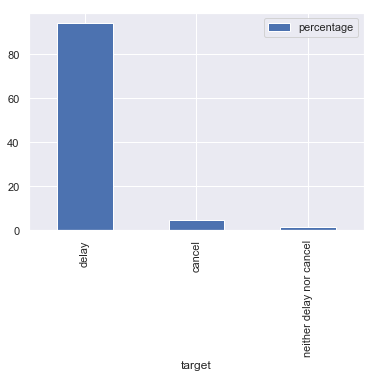

In [28]:
target_group.plot(kind='bar', x='target', y='percentage')

In [29]:
target_group_airline = pd.DataFrame({'count' : departures_extended.groupby(['airline_name','target']).size()}).reset_index()
target_group_airline_pivot = pd.DataFrame(target_group_airline.pivot('airline_name','target','count').to_records())
target_group_airline_pivot.shape

(875, 4)

In [30]:
target_group_airline_pivot.head()

,airline_name,cancel,delay,neither delay nor cancel
0,21 Air,1.0,NaN,NaN
1,ABX Air,7.0,58.0,2.0
2,ASL Airlines Belgium,6.0,5.0,NaN
3,ASL Airlines France,118.0,62.0,5.0
4,Adria Airways,3.0,56.0,NaN


In [31]:
target_group_airline_pivot.sort_values(['cancel','delay'],ascending=False)[0:20]

,airline_name,cancel,delay,neither delay nor cancel
135,American Airlines,508.0,9245.0,34.0
524,Lufthansa,381.0,6944.0,10.0
657,Qantas,365.0,1534.0,4.0
821,United Airlines,359.0,9078.0,30.0
728,Southwest Airlines,230.0,2962.0,9.0
556,NetJets,204.0,NaN,2.0
826,United Express,188.0,4986.0,18.0
251,Condor,153.0,371.0,3.0
3,ASL Airlines France,118.0,62.0,5.0
276,Delta Air Lines,117.0,7086.0,9.0


In [32]:
target_group_airline_pivot.sort_values(['delay','cancel'],ascending=False)[0:20]

,airline_name,cancel,delay,neither delay nor cancel
135,American Airlines,508.0,9245.0,34.0
821,United Airlines,359.0,9078.0,30.0
193,British Airways,103.0,7945.0,45.0
276,Delta Air Lines,117.0,7086.0,9.0
524,Lufthansa,381.0,6944.0,10.0
861,easyJet,90.0,6294.0,125.0
687,Ryanair,30.0,5943.0,92.0
64,Air France,102.0,5143.0,32.0
826,United Express,188.0,4986.0,18.0
281,Delta Connection,96.0,4413.0,11.0
